Rapport de classification :

                   precision    recall  f1-score   support

 pollution faible       0.91      0.91      0.91        22
pollution moyenne       0.96      1.00      0.98        52
 pollution élevée       1.00      0.50      0.67         4

         accuracy                           0.95        78
        macro avg       0.96      0.80      0.85        78
     weighted avg       0.95      0.95      0.94        78



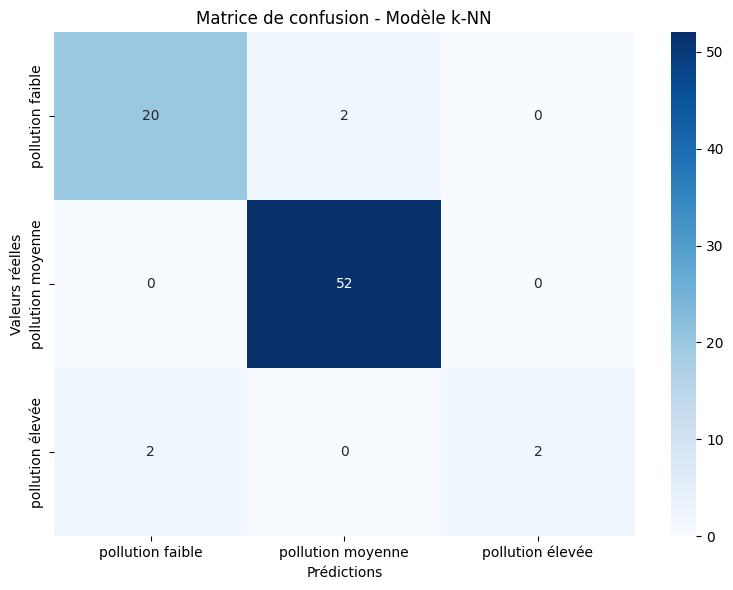

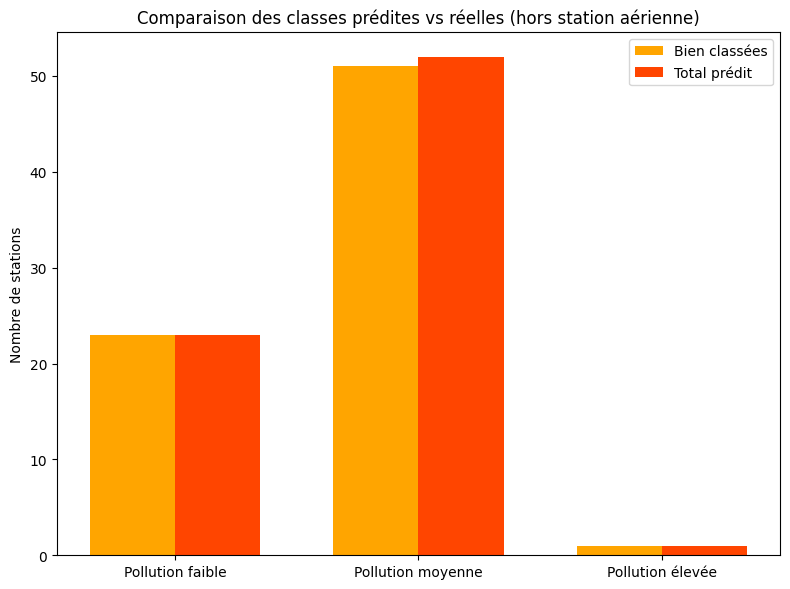

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


# chargement des données et localisation du fichier train.csv automatiquement
base_dir = os.path.dirname(os.getcwd())  # monte d’un niveau
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")

# chargement du fichier CSV
df = pd.read_csv(csv_path)
df = df[df['niveau_pollution'] != 'pas de données']

# Suppression des colonnes inutiles
df = df.drop(columns=[
    'Identifiant station', 'Nom de la Station', 'Niveau de pollution aux particules',
    'Incertitude', 'Action(s) QAI en cours', 'air'
])

# Suppression des lignes inutilisables
df = df[df['niveau_pollution'] != 'pas de données']

# Encodage des colonnes catégorielles
le_ligne = LabelEncoder()
le_reco = LabelEncoder()
le_nivpol = LabelEncoder()
le_cible = LabelEncoder()

df['Nom de la ligne'] = le_ligne.fit_transform(df['Nom de la ligne'])
df['Recommandation de surveillance'] = le_reco.fit_transform(df['Recommandation de surveillance'])
df['Niveau de pollution'] = le_nivpol.fit_transform(df['Niveau de pollution'])
df['niveau_pollution'] = le_cible.fit_transform(df['niveau_pollution'])

# Séparation X / y
X = df.drop(columns=['niveau_pollution'])
y = df['niveau_pollution']

# Découpage des données en train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline avec standardisation et k-NN
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Entraînement
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

# Affichage du rapport de classification
print("Rapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=le_cible.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_cible.classes_,
            yticklabels=le_cible.classes_)
plt.title("Matrice de confusion - Modèle k-NN")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

# Lignes = vraies classes, Colonnes = prédictions
# Classes : Pollution faible, moyenne, élevée
cm = np.array([
    [23, 1, 0],  # Vraie classe = pollution faible
    [0, 51, 0],  # Vraie classe = pollution moyenne
    [0, 0, 1]    # Vraie classe = pollution élevée
])

# Noms des classes
classes = ['Pollution faible', 'Pollution moyenne', 'Pollution élevée']

# Axes X
x = np.arange(len(classes))
bar_width = 0.35

# Calcul des valeurs à afficher
true_values = np.diag(cm)                # Correctement classées
predicted_totals = np.sum(cm, axis=0)    # Total prédit par classe

# Tracer le graphique
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, true_values, width=bar_width, label='Bien classées', color='orange')
plt.bar(x + bar_width/2, predicted_totals, width=bar_width, label='Total prédit', color='orangered')

plt.xticks(x, classes)
plt.ylabel("Nombre de stations")
plt.title("Comparaison des classes prédites vs réelles")
plt.legend()
plt.tight_layout()
plt.show()

